In [1]:
%load_ext autoreload
%autoreload 2

In [27]:
import zarr
import numpy as np
import matplotlib.pyplot as plt
import torch
import pickle
from pathlib import Path
from tqdm import tqdm

from torch.utils.data import DataLoader

## Look at the robot_state data in the raw sim data

In [16]:
dataset_path = "/data/scratch/ankile/furniture-data/data/processed/sim/image_small/one_leg/data_batch_32.zarr"

data = zarr.open(dataset_path, mode="r")

[[84 84 84]
 [84 84 84]
 [84 84 84]
 [84 84 84]]


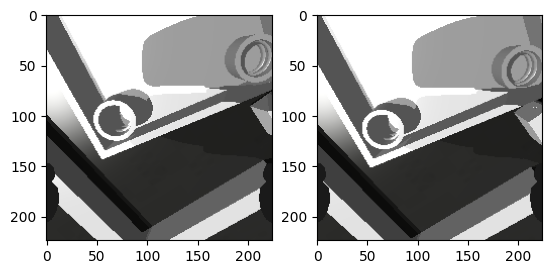

In [4]:
img = data["color_image1"][0:2]

print(img[0, 0, 0:4, :])

fig, (ax1, ax2) = plt.subplots(1, 2)

# Show the images in color
ax1.imshow(img[0])
ax2.imshow(img[1])

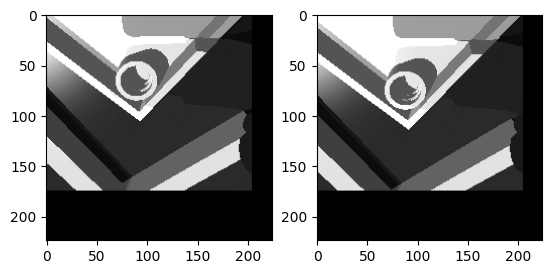

In [ ]:
def random_translate(img):
    max_translation = 50
    H, W, _ = img.shape[1:]
    translated_images = np.zeros_like(img)

    translation_height = np.random.randint(-max_translation, max_translation)
    translation_width = np.random.randint(-max_translation, max_translation)

    # Calculate the indices for zero-padded array
    start_height = max(translation_height, 0)
    end_height = H + min(translation_height, 0)
    start_width = max(translation_width, 0)
    end_width = W + min(translation_width, 0)

    # Calculate the indices for the original image
    start_height_orig = -min(translation_height, 0)
    end_height_orig = H - max(translation_height, 0)
    start_width_orig = -min(translation_width, 0)
    end_width_orig = W - max(translation_width, 0)

    # Index into the zero-padded array and place the original image
    translated_images[:, start_height:end_height, start_width:end_width, :] = img[
        :, start_height_orig:end_height_orig, start_width_orig:end_width_orig, :
    ]

    return translated_images


translated_images = random_translate(img)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(translated_images[0])
ax2.imshow(translated_images[1])

In [18]:
data["episode_ends"][:]

array([ 475,  993, 1441, 1961, 2411, 2890, 3381, 3913, 4379, 4863],
      dtype=uint32)

## Test the augmentation module

In [17]:
from src.dataset.augmentation import ImageAugmentation
from src.dataset.normalizer import StateActionNormalizer

In [13]:
aug = ImageAugmentation(random_translate=True, color_jitter=True, random_rotate=True)

In [14]:
img = data["color_image2"][125]

100%|██████████| 4/4 [00:00<00:00, 50.99it/s]


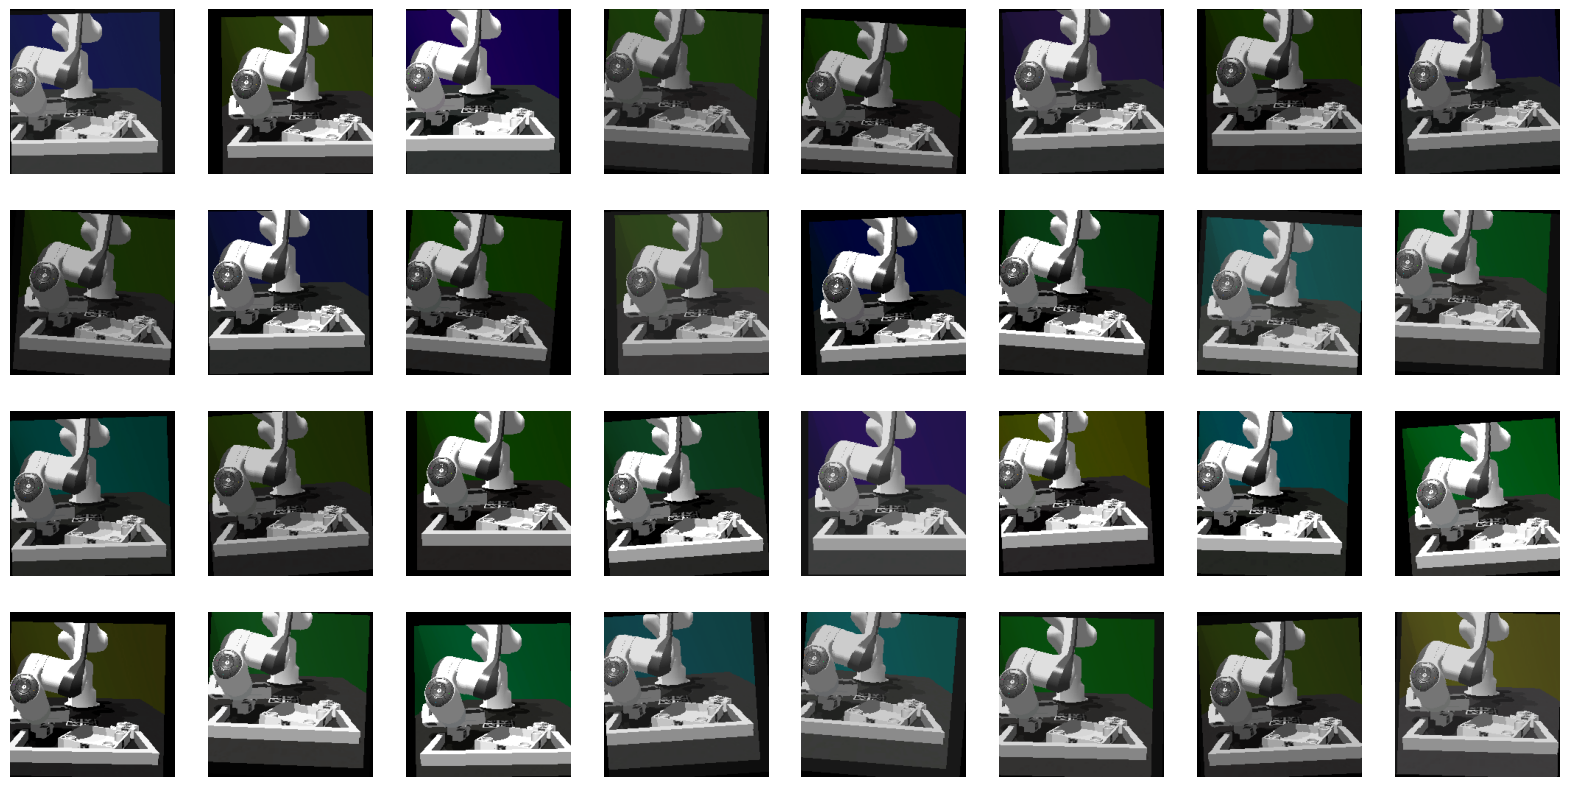

In [15]:
# Make a grid of 4 by 8 images, each with different augmentation
fig, axes = plt.subplots(4, 8, figsize=(20, 10))

for i in tqdm(range(4)):
    for j in range(8):
        img_aug = aug(img)
        axes[i, j].imshow(img_aug)
        axes[i, j].axis("off")

In [24]:
# Validate that the augmentation is working in the dataset class
from src.dataset.dataset import FurnitureImageDataset

dataset = FurnitureImageDataset(
    dataset_path=dataset_path,
    action_horizon=8,
    obs_horizon=2,
    pred_horizon=16,
    augment_image=True,
    normalizer=StateActionNormalizer(),
)

Loading dataset of 699 episodes


In [28]:
loader = DataLoader(dataset, batch_size=8, shuffle=True)

100%|██████████| 8/8 [00:00<00:00, 969.53it/s]


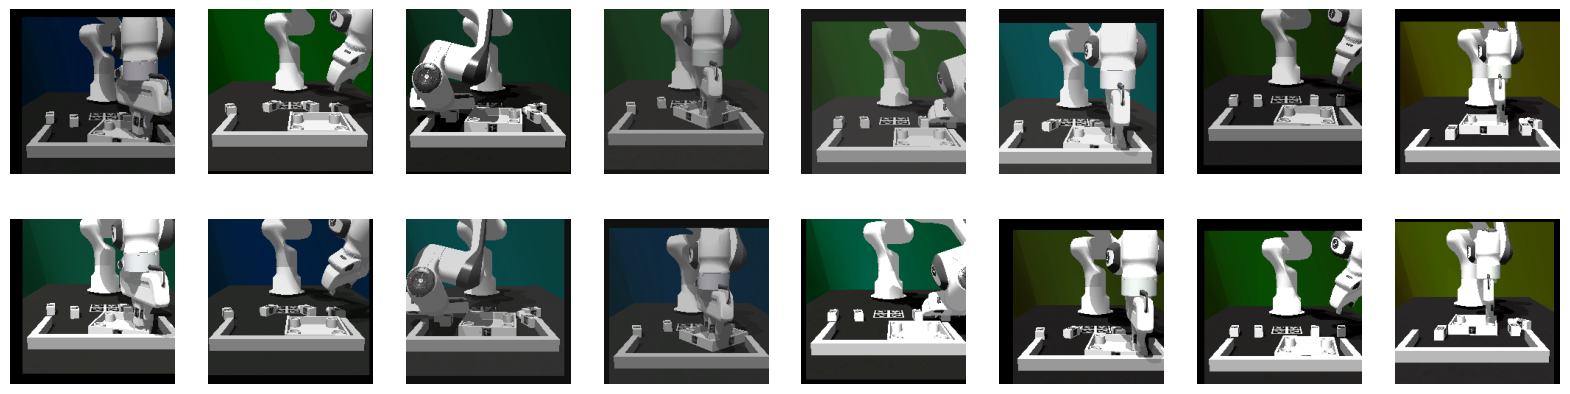

In [33]:
# Get 8 pairs of images and show them
fig, axes = plt.subplots(2, 8, figsize=(20, 5))

batch = next(iter(loader))

for i in tqdm(range(8)):
    axes[0, i].imshow(batch["color_image2"][i][0])
    axes[1, i].imshow(batch["color_image2"][i][1])

    # TUrn off the axes
    axes[0, i].axis("off")
    axes[1, i].axis("off")